# Нейрон с различными функциями активации

В этом задании нужно будет: 
- самостоятельно реализовать класс **`Neuron()`** с различными функциями активации (ReLU, LeakyReLU и ELU)

- обучить и протестировать этот класс на сгенерированных и реальных данных

**Достаточно реализовать ReLU и ещё одну из двух.**

In [30]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import time

In [31]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

В данном случае мы снова решаем задачу бинарной классификации (2 класса: 1 или 0). Мы уже выяснили (в ноутбуке про `logloss`), что плохо брать для классификации квадратичную функцию потерь, однако здесь для простоты возьмём её:

$$
Loss(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2
$$  

Здесь $w \cdot X_i$ - скалярное произведение, а $\hat{y_i} = \sigma(w \cdot X_i) =\frac{1}{1+e^{-w \cdot X_i}} $ - сигмоида ($i$ -- номер объекта в выборке). 

In [32]:
def Loss(y_pred, y):
    y_pred = y_pred.reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    return 0.5 * np.mean((y_pred - y) ** 2)

Далее будут предложены несколько функций активации, и Вам нужно реализовать класс `Neuron` по аналогии с тем, как это было на семинаре. Сам принцип тот же, но меняются формула обновления весов и формула предсказания.

<h2 style="text-align: center;"><b>Нейрон с ReLU (Recitified Linear Unit)</b></h2>  

ReLU самая часто используемая (по крайней мере, пару лет назад) функция активации в нейронных сетях. Выглядит она очень просто:

\begin{equation*}
ReLU(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Или по-другому:

$$
ReLU(x) = \max(0, x)
$$

В (свободном) переводе Rectified Linear Unit = "Усечённая линейная функция". Собственно, мы по сути просто не даём проходить отрицательным числам.

Производная здесь берётся как производная от кусочно-заданной функции, то есть на участках, где функция гладкая, и в нуле её доопредляют нулём:

\begin{equation*}
ReLU'(x) = 
 \begin{cases}
   0, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Подставим ReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ReLU(w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
    y_i^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

(помните, что $w \cdot X_i$ -- это число в данном случае (результат скалярного произведения двух векторов)).

Тогда формула для обновления весов при градиентном спуске будет такая (в матричном виде, рекмоендуем вывести самим то, как это получается из формулы для одного объекта):

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   0, &{w \cdot X_i \le 0}\\
   \frac{1}{n} X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

(напоминаем, что здесь $w \cdot X$ -- матричное произведение вектора $w$ (ведь вектор -- тоже матрица, не так ли?) и матрицы $X$ )

Почему в первом случае будет 0? Потому что в формулу $y_i^2$ не входят веса , а мы берём производную именно по весам $w$.

* Реализуйте ReLU и её производную:

In [33]:
def relu(x):
    """ReLU-функция"""
    return np.where(x <=0, 0, x)

In [34]:
def relu_derivative(x):
    """Производная ReLU"""
    return np.where(x <=0, 0, 1)

Теперь нужно написать нейрон с ReLU. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [35]:
class NeuronReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return relu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b).reshape(-1, 1)
        return y_pred
    
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        calc_w = np.zeros((X.shape[1], 1))
        calc_b = 0.

        for i in range(len(X)):
            calc_w = calc_w + relu_derivative(y_pred[i]) * X[i].reshape(1, -1).T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1))
            calc_b += relu_derivative(y_pred[i])*(y_pred[i][0] - y[i][0])
        self.w = self.w - learning_rate * calc_w / n
        self.b = self.b - learning_rate * calc_b / n
        
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        # if weights were not initialized
        if self.w is None: 
          self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
          self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        t0 = 0
        for i in range(num_epochs):
          time_start = time.time()
          if i % 1000 == 0:
            if t0 % 60 == 0:
              minutes = t0 % 60
            else:
              minutes = (t0 - (t0 % 60))/60
            print("Epochs:", i, "Total time:",minutes,"minutes", t0 - (minutes * 60), "secs")
          y_pred = self.forward_pass(X)
          Loss_values.append(Loss(y_pred, y))
          self.backward_pass(X, y, y_pred)
          t0 = t0 + time.time() - time_start
          if i == num_epochs - 1:
            if t0 % 60 == 0:
              minutes = t0 % 60
            else:
              minutes = (t0 - (t0 % 60))/60
            print("Epochs:", i, "Total time:", minutes,"minutes", t0 - (minutes * 60), "secs")
            print("Total time with num_epochs =", num_epochs, ":", minutes,"minutes", t0 - (minutes * 60), "secs")
          
        return Loss_values
        
    def predict(self, X, div):
      return np.array(self.forward_pass(X) > div).ravel()

<h3 style="text-align: center;"><b>Тестирование нейрона с ReLU</b></h3>  

Здесь вам нужно самим протестировать новый нейрон **на тех же данных** ("Яблоки и Груши" и "Голос") по аналогии с тем, как это было проделано с перцептроном.
В итоге нужно вывести: 
* график, на котором будет показано, как изменяется функция потерь $Loss$ в зависимости от числа итераций обучения
* график с раскраской выборки нейроном

***ПРИМЕЧАНИЕ***: пожалуйста, почаще проверяйте `.shape` у матриц и векторов: `self.w`, `X` и `y` внутри класса. Очень часто ошибка решается транспонированием или `.reshape()`'ом. Не забывайте проверять, что на что Вы умножаете и какой вектор (какой размер) хотите получить на выходе -- это очень помогает не запутаться.

## Apples and Pears dataset

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
data_a_p = pd.read_csv('/content/drive/MyDrive/data/apples_pears.csv')
X = data_a_p.iloc[:,:-1].values 
y = data_a_p['target'].values.reshape((-1, 1))  

Epochs: 0 Total time: 0 minutes 0 secs
Epochs: 299 Total time: 0.0 minutes 6.557562589645386 secs
Total time with num_epochs = 300 : 0.0 minutes 6.557562589645386 secs


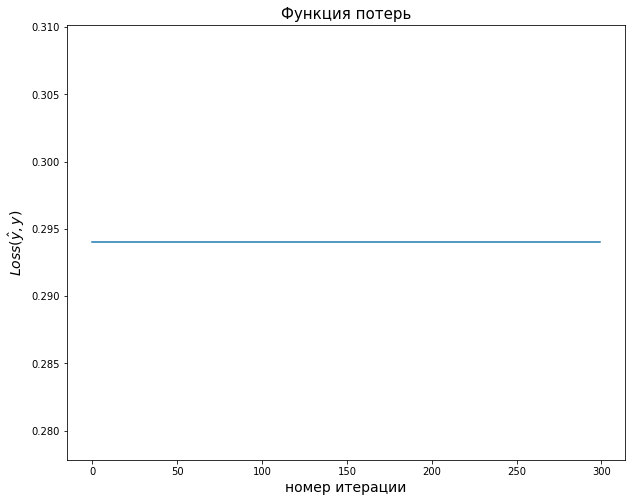

CPU times: user 6.7 s, sys: 589 ms, total: 7.29 s
Wall time: 6.76 s


In [38]:
%%time

neuron = NeuronReLU()
Loss_values = neuron.fit(X, y)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Скорее всего сейчас у вас лосс -- это прямая линия, и вы видите, что веса не обновляются. Но почему?

Всё просто -- если присмотреться, то видно, что self.w и self.b иницилизируются нулями в начале `.fit()`-метода. Если расписать, как будет идти обновление, то видно, что из-за ReLU веса просто-напросто не будут обновляться, если начать с инициализации нулями. 

Это -- одна из причин, по которой в нейронных сетях веса инициализируют случаными числами (обычно из отрезка [0, 1)).

Обучите нейрон, инициализировав случайно веса (поставьте 10000 итераций). 

Закомментируйте инициализацию нулями в функции `.fit()` класса `NeuronReLU` 

Epochs: 0 Total time: 0 minutes 0 secs
Epochs: 1000 Total time: 0.0 minutes 22.277262449264526 secs
Epochs: 2000 Total time: 0.0 minutes 44.053444147109985 secs
Epochs: 3000 Total time: 1.0 minutes 6.362578868865967 secs
Epochs: 4000 Total time: 1.0 minutes 27.521796464920044 secs
Epochs: 5000 Total time: 1.0 minutes 49.27440333366394 secs
Epochs: 6000 Total time: 2.0 minutes 10.731251001358032 secs
Epochs: 7000 Total time: 2.0 minutes 32.46581172943115 secs
Epochs: 8000 Total time: 2.0 minutes 54.227920055389404 secs
Epochs: 9000 Total time: 3.0 minutes 15.763268947601318 secs
Epochs: 9999 Total time: 3.0 minutes 37.59833288192749 secs
Total time with num_epochs = 10000 : 3.0 minutes 37.59833288192749 secs


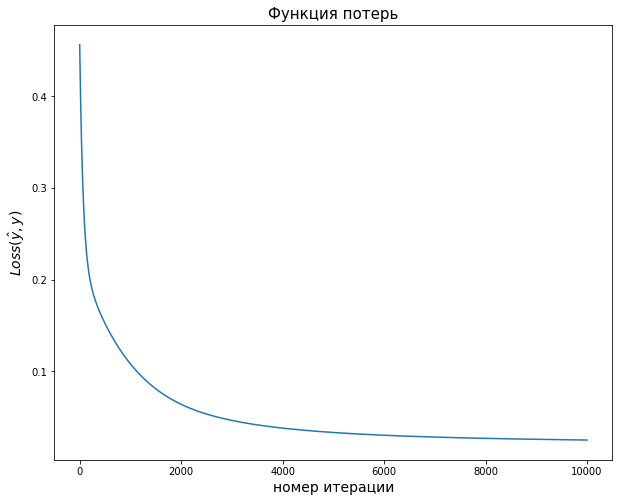

CPU times: user 3min 37s, sys: 18 s, total: 3min 55s
Wall time: 3min 37s


In [39]:
%%time

neuron = NeuronReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Посмотрим, как предсказывает этот нейрон:

Best accuracy score:  0.985  if division =  0.65


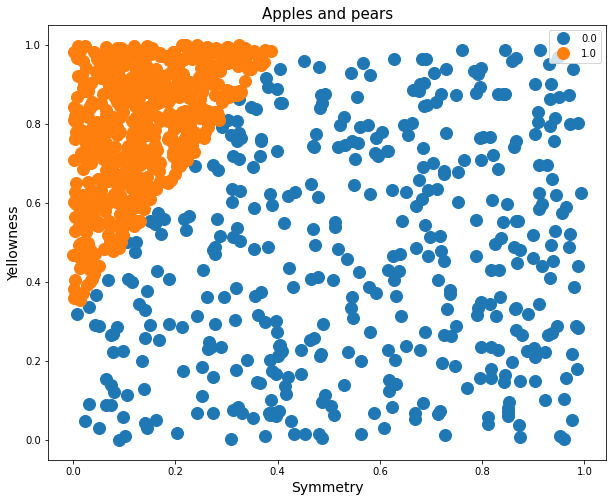

In [40]:
from sklearn.metrics import accuracy_score
best = []
for i in list(np.arange(0.1, 1.0, 0.01)):
  best.append([accuracy_score(y, neuron.predict(X, i).reshape(-1, 1)), i])
print('Best accuracy score: ', max(best)[0], " if division = ", round(max(best)[1], 2))
division = max(best)[1]
plt.figure(figsize=(10, 8))
groups = data_a_p.groupby('target')
for name, group in groups:
    plt.plot(group.symmetry, group.yellowness, marker='o', linestyle='', markersize=12, label=name)
plt.legend()
plt.title('Apples and pears', fontsize=15)
plt.xlabel('Symmetry', fontsize=14)
plt.ylabel('Yellowness', fontsize=14)
plt.show();

## Voice dataset

In [41]:
from sklearn.preprocessing import MinMaxScaler
data_v = pd.read_csv('/content/drive/MyDrive/data/voice.csv')
data_v['label'] = data_v['label'].apply(lambda x: 1 if x == 'male' else 0)
data_cols = data_v.columns.values
min_max_scaler = MinMaxScaler()
data_v = pd.DataFrame(min_max_scaler.fit_transform(data_v), columns=data_cols)

In [42]:
# Shuffle data
data_v = data_v.sample(frac=1)
data_v.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
254,0.433168,0.711766,0.478368,0.262317,0.720885,0.544951,0.994565,0.970740,0.471268,0.611698,0.000000,0.433168,0.227750,0.057331,0.929285,0.000000,0.006452,0.000000,0.000000,0.000000,1.0
2171,0.719788,0.179688,0.732210,0.715875,0.724003,0.076382,0.073754,0.006827,0.443041,0.252526,0.634093,0.719788,0.645058,0.030899,0.771005,0.216414,0.350538,0.297713,0.290773,0.141817,0.0
969,0.711275,0.430318,0.724260,0.540115,0.873196,0.403839,0.036570,0.001830,0.676119,0.367570,0.423803,0.711275,0.365841,0.192595,0.929285,0.246698,0.040860,0.256969,0.256438,0.099383,1.0
940,0.727208,0.430692,0.831712,0.534805,0.878252,0.414264,0.038517,0.002318,0.646242,0.314970,0.831960,0.727208,0.390694,0.201509,0.990585,0.405151,0.040860,0.260186,0.259657,0.169754,1.0
331,0.560281,0.446059,0.663454,0.411420,0.719671,0.388742,0.068893,0.005676,0.690060,0.546806,0.369412,0.560281,0.265416,0.207017,0.799959,0.181913,0.215054,0.033595,0.029283,0.352052,1.0


In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_v.drop("label", axis=1), data_v.label, train_size = 0.7, random_state=RANDOM_SEED)

In [44]:
neuron = NeuronReLU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1)[0])
loss_values = neuron.fit(X_train.values, y_train.values.reshape(-1, 1), num_epochs=5000)

Epochs: 0 Total time: 0 minutes 0 secs
Epochs: 1000 Total time: 1.0 minutes 16.540305137634277 secs
Epochs: 2000 Total time: 2.0 minutes 33.961222648620605 secs
Epochs: 3000 Total time: 3.0 minutes 49.236061573028564 secs
Epochs: 4000 Total time: 5.0 minutes 2.3898658752441406 secs
Epochs: 4999 Total time: 6.0 minutes 16.295592069625854 secs
Total time with num_epochs = 5000 : 6.0 minutes 16.295592069625854 secs


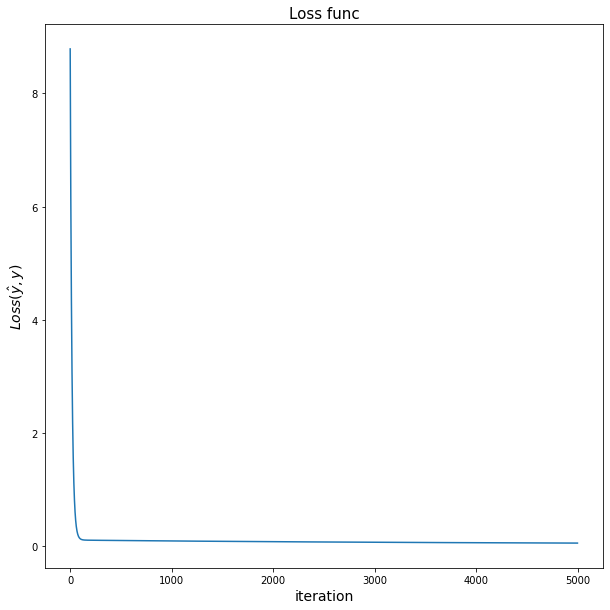

Best accuracy score:  0.8853838065194533  if division =  0.47


In [45]:
plt.figure(figsize=(10, 10))
plt.plot(loss_values)
plt.title('Loss func', fontsize=15)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

best = []
for i in list(np.arange(0.1, 1.0, 0.01)):
  best.append([accuracy_score(y_test, neuron.predict(X_test.values, i).reshape(-1, 1)), i])
print('Best accuracy score: ', max(best)[0], " if division = ", round(max(best)[1], 2))

Есть одна тенденция: пороговая функция активации и сигмоида (обычно всё же только сигмоида) чаще используются именно на **выходном слое** нейросети в задаче классификации -- ими предсказывают вероятности объектов принадлежать одному из классов, в то время как продвинутые функции активации (ReLU и те, что будут дальше) используются внутри нейросети, то есть в **скрытых слоях**.

Нужно понимать, что ReLU не может вернуть отрицательные числа.

**Плюсы ReLU:**

* дифференцируемая (с доопределе
нием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде

**Возможные минусы ReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* зануляет все отрицательные входы, тем самым веса у занулённых нейронов могут часто *не обновляться*, эту проблему иногда называют *мёртвые нейроны*

С последней проблемой можно побороться, а именно:

<h2 style="text-align: center;"><b>Нейрон с LeakyReLU (Leaky Recitified Linear Unit)</b></h2>  

LeakyReLU очень слабо отличается от ReLU, но часто помогает сети обучаться быстрее, поскольку нет проблемы "мёртвых нейронов":

\begin{equation*}
LeakyReLU(x) =
 \begin{cases}
   \alpha x, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
LeakyReLU'(x) = 
 \begin{cases}
   \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

График этой функции:

<img src="https://cdn-images-1.medium.com/max/1600/0*UtLlZJ80TMIM7kXk." width=400 height=300>

Подставим LeakyReLu в Loss:

$$
Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (LeakyReLU(w \cdot X_i) - y_i)^2 =
\begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha \cdot w \cdot X_i - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}
$$  

Формула для обновления весов при градиентном спуске:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   \alpha X_i^T (w \cdot X_i - y), &{w \cdot X_i \le 0}\\
    X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте LeakyReLU и её производную:

In [46]:
def leaky_relu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return np.where(x <= 0, alpha * x, x)

In [47]:
def leaky_relu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return np.where(x <= 0, alpha, 1)

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [48]:
class NeuronLeakyReLU:
    def __init__(self, w=None, b=0, alpha=0.01):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        self.alpha = alpha
        
        
    def activate(self, x):
        return leaky_relu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b).reshape(-1,1)
        return y_pred
        
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        calc_w = np.zeros((X.shape[1], 1))
        calc_b = 0.
        for i in range(len(X)):
            calc_w = calc_w + leaky_relu_derivative(y_pred[i]) * X[i].reshape(1, -1).T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1))
            calc_b += leaky_relu_derivative(y_pred[i]) * (y_pred[i][0] - y[i][0])
        self.w = self.w - learning_rate * calc_w / n
        self.b = self.b - learning_rate * calc_b / n

    
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        if self.w is None:
          self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
          self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        t0 = 0
        for i in range(num_epochs):
            time_start = time.time()
            if i % 1000 == 0:
              if t0 % 60 == 0:
                minutes = t0 % 60
              else:
                minutes = (t0 - (t0 % 60))/60
              print("Epochs:", i, "Total time:", minutes,"minutes", t0 - (minutes * 60), "secs")
            y_pred = self.forward_pass(X)
            Loss_values.append(Loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
            t0 = t0 + time.time() - time_start
            if i == num_epochs - 1:
              if t0 % 60 == 0:
                minutes = t0 % 60
              else:
                minutes = (t0 - (t0 % 60))/60
              print("Epochs:", i, "Total time:", minutes,"minutes", t0 - (minutes * 60), "secs")
              print("Total time with num_epochs =", num_epochs, ":", minutes,"minutes", t0 - (minutes * 60), "secs")        
        return Loss_values
    def predict(self, X, div):
      return np.array(self.forward_pass(X) > div).ravel()

## Apples and pears dataset

Epochs: 0 Total time: 0 minutes 0 secs
Epochs: 1000 Total time: 0.0 minutes 18.542518854141235 secs
Epochs: 2000 Total time: 0.0 minutes 37.41206932067871 secs
Epochs: 3000 Total time: 0.0 minutes 56.36016249656677 secs
Epochs: 4000 Total time: 1.0 minutes 15.648712635040283 secs
Epochs: 5000 Total time: 1.0 minutes 34.7702534198761 secs
Epochs: 6000 Total time: 1.0 minutes 53.93035173416138 secs
Epochs: 7000 Total time: 2.0 minutes 12.791663646697998 secs
Epochs: 8000 Total time: 2.0 minutes 31.642170667648315 secs
Epochs: 9000 Total time: 2.0 minutes 50.35551428794861 secs
Epochs: 9999 Total time: 3.0 minutes 9.438028812408447 secs
Total time with num_epochs = 10000 : 3.0 minutes 9.438028812408447 secs


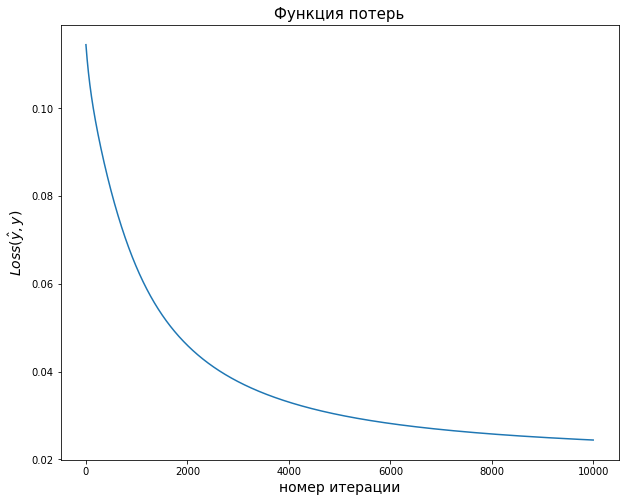

Best accuracy score:  0.988  if division =  0.65


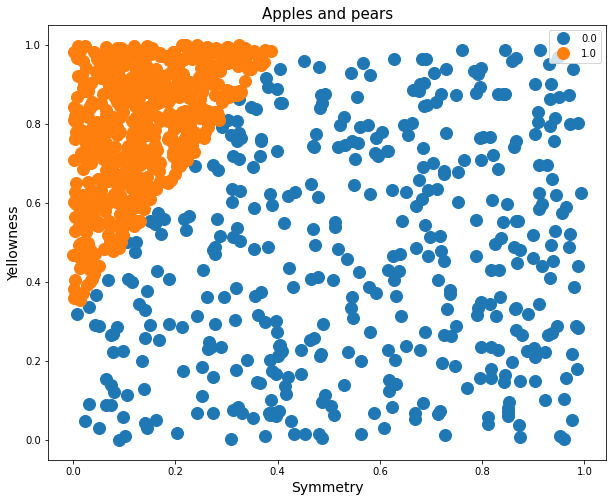

In [53]:
X = data_a_p.iloc[:,:2].values  # матрица объекты-признаки
y = data_a_p['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)
neuronL= NeuronLeakyReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values_L = neuronL.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values_L)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

best = []
for i in list(np.arange(0.1, 1.0, 0.01)):
  best.append([accuracy_score(y, neuronL.predict(X, i).reshape(-1, 1)), i])
print('Best accuracy score: ', max(best)[0], " if division = ", round(max(best)[1], 2))
division = max(best)[1]
plt.figure(figsize=(10, 8))
groups = data_a_p.groupby('target')
for name, group in groups:
    plt.plot(group.symmetry, group.yellowness, marker='o', linestyle='', markersize=12, label=name)
plt.legend()
plt.title('Apples and pears', fontsize=15)
plt.xlabel('Symmetry', fontsize=14)
plt.ylabel('Yellowness', fontsize=14)
plt.show();

## Voice dataset

Epochs: 0 Total time: 0 minutes 0 secs
Epochs: 1000 Total time: 1.0 minutes 11.148365259170532 secs
Epochs: 2000 Total time: 2.0 minutes 23.279657125473022 secs
Epochs: 3000 Total time: 3.0 minutes 35.42526888847351 secs
Epochs: 4000 Total time: 4.0 minutes 47.63766312599182 secs
Epochs: 4999 Total time: 5.0 minutes 59.62086606025696 secs
Total time with num_epochs = 5000 : 5.0 minutes 59.62086606025696 secs


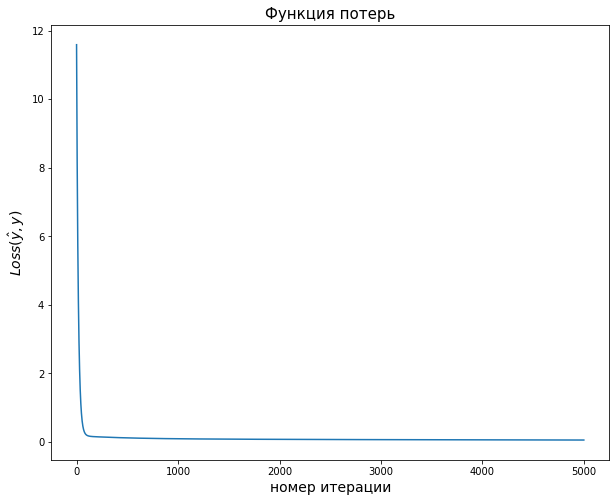

Best accuracy score:  0.889589905362776  if division =  0.49


In [54]:
data_v = data_v.sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(data_v.drop("label", axis=1), data_v.label, train_size = 0.7, random_state=42)
neuron_L = NeuronLeakyReLU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1)[0])
loss_values_L = neuron_L.fit(X_train.values, y_train.values.reshape(-1, 1), num_epochs=5000)

plt.figure(figsize=(10, 8))
plt.plot(loss_values_L)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

best = []
for i in list(np.arange(0.1, 1.0, 0.01)):
  best.append([accuracy_score(y_test, neuron_L.predict(X_test.values, i).reshape(-1, 1)), i])
print('Best accuracy score: ', max(best)[0], " if division = ", round(max(best)[1], 2))

**Плюсы LeakyReLU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU

**Возможные минусы LeakyReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* немного не устойчива к "шуму" (см. лекции Стэнфорда)

<h2 style="text-align: center;"><b>Нейрон с ELU (Exponential Linear Unit)</a></b></h2>  

ELU -- не так давно предложенная (в 2015 году) функция активации, которая, как говорят авторы статьи, лучше LeakyReLU. Вот формула ELU:

\begin{equation*}
ELU(\alpha, x) =
 \begin{cases}
   \alpha (e^x - 1), &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
ELU'(x) = 
 \begin{cases}
   ELU(\alpha, x) + \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Здесь в производной использован постой трюк -- сделано $- \alpha + \alpha$, чтобы вычислять было проще.

График этой функции:

<img src="http://p0.ifengimg.com/pmop/2017/0907/A004001DD141881BFD8AD62E5D31028C3BE3FAD1_size14_w446_h354.png" width=500 height=400>

Подставим LeakyReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ELU(\alpha, w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha (e^{w \cdot X_i} - 1) - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

Здесь вам нужно выписать самим град спуск для весов. Брать производную "в лоб" некрасиво и неудобно. Нужно воспользоваться **правилом цепочки**, оно же **правило взятия производной сложной функции**:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   , &{w \cdot X_i \le 0}\\
   , &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте ELU и её производную:

In [56]:
def elu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return np.where(x > 0, x, alpha*(np.exp(x) - 1))

In [57]:
def elu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return np.where(x > 0, 1, elu(x, alpha=alpha) + alpha)


Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [52]:
class NeuronELU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return elu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b).reshape(-1,1)
        return y_pred
        
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        calc_w = np.zeros((X.shape[1], 1))
        calc_b = 0.
        for i in range(len(X)):
          if y_pred[i] > 0:
            calc_w = calc_w + X[i].reshape(1, -1).T @ (y_pred[i].reshape(1, 1) - y[i].reshape(1, 1))
            calc_b += (y_pred[i][0] - y[i][0])
          else:
            calc_w = calc_w + elu_derivative(y_pred[i]) * X[i].reshape(1, -1).T @ (elu_derivative(y_pred[i]).reshape(1, 1) - y[i].reshape(1, 1))
            calc_b += elu_derivative(y_pred[i]) *(elu_derivative(y_pred[i])[0] - y[i][0])
        self.w = self.w - learning_rate * calc_w / n
        self.b = self.b - learning_rate * calc_b / n
    
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        if self.w is None:
          self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
          self.b = 0  # смещение (число)
        Loss_values = []  # значения функции потерь на различных итерациях обновления весов
        t0 = 0
        for i in range(num_epochs):
            time_start = time.time()
            if i % 1000 == 0:
              if t0 % 60 == 0:
                minutes = t0 % 60
              else:
                minutes = (t0 - (t0 % 60))/60
              print("Epochs:", i, "Total time:", minutes,"minutes", t0 - (minutes * 60), "secs")
            y_pred = self.forward_pass(X)
            Loss_values.append(Loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
            t0 = t0 + time.time() - time_start
            if i == num_epochs - 1:
              if t0 % 60 == 0:
                minutes = t0 % 60
              else:
                minutes = (t0 - (t0 % 60))/60
              print("Epochs:", i, "Total time:", minutes,"minutes", t0 - (minutes * 60), "secs")
              print("Total time with num_epochs =", num_epochs, ":", minutes,"minutes", t0 - (minutes * 60), "secs")        
        return Loss_values

    def predict(self, X, div):
      return np.array(self.forward_pass(X) > div).ravel()

## Apples and pears dataset

Epochs: 0 Total time: 0 minutes 0 secs
Epochs: 1000 Total time: 0.0 minutes 7.391632556915283 secs
Epochs: 2000 Total time: 0.0 minutes 16.453388929367065 secs
Epochs: 3000 Total time: 0.0 minutes 28.28640103340149 secs
Epochs: 4000 Total time: 0.0 minutes 42.32881140708923 secs
Epochs: 5000 Total time: 0.0 minutes 57.33958053588867 secs
Epochs: 6000 Total time: 1.0 minutes 13.540822267532349 secs
Epochs: 7000 Total time: 1.0 minutes 30.689724683761597 secs
Epochs: 8000 Total time: 1.0 minutes 48.34025955200195 secs
Epochs: 9000 Total time: 2.0 minutes 6.814081192016602 secs
Epochs: 9999 Total time: 2.0 minutes 25.685643434524536 secs
Total time with num_epochs = 10000 : 2.0 minutes 25.685643434524536 secs


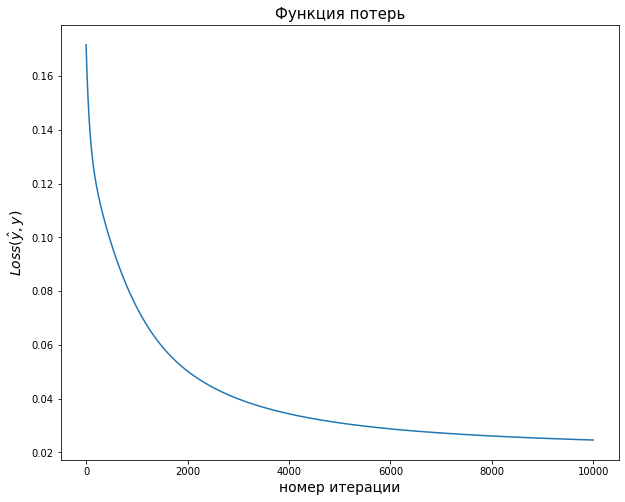

Best accuracy score:  0.988  if division =  0.65


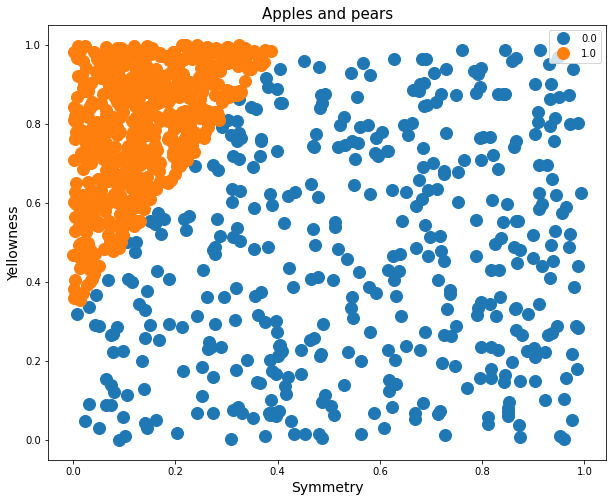

In [58]:
X = data_a_p.iloc[:,:2].values  # матрица объекты-признаки
y = data_a_p['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)
neuronELU= NeuronELU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
Loss_values_ELU = neuronELU.fit(X, y, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values_ELU)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

best = []
for i in list(np.arange(0.1, 1.0, 0.01)):
  best.append([accuracy_score(y, neuronELU.predict(X, i).reshape(-1, 1)), i])
print('Best accuracy score: ', max(best)[0], " if division = ", round(max(best)[1], 2))
division = max(best)[1]
plt.figure(figsize=(10, 8))
groups = data_a_p.groupby('target')
for name, group in groups:
    plt.plot(group.symmetry, group.yellowness, marker='o', linestyle='', markersize=12, label=name)
plt.legend()
plt.title('Apples and pears', fontsize=15)
plt.xlabel('Symmetry', fontsize=14)
plt.ylabel('Yellowness', fontsize=14)
plt.show();

## Voice dataset

Epochs: 0 Total time: 0 minutes 0 secs
Epochs: 1000 Total time: 1.0 minutes 12.581898927688599 secs
Epochs: 2000 Total time: 2.0 minutes 24.731083631515503 secs
Epochs: 3000 Total time: 3.0 minutes 36.48452615737915 secs
Epochs: 4000 Total time: 4.0 minutes 48.67569446563721 secs
Epochs: 4999 Total time: 6.0 minutes 0.8128952980041504 secs
Total time with num_epochs = 5000 : 6.0 minutes 0.8128952980041504 secs


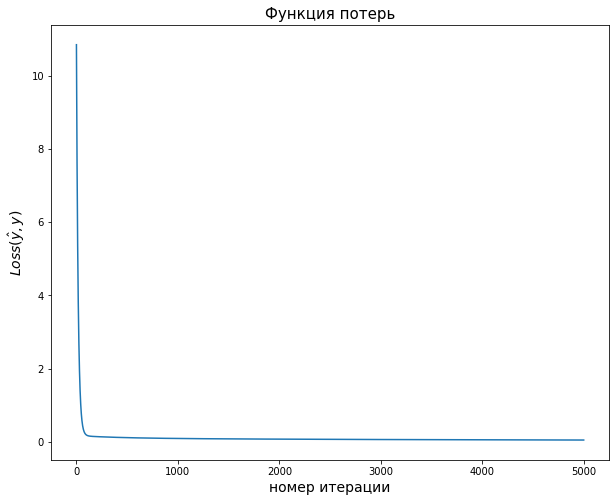

Best accuracy score:  0.8958990536277602  if division =  0.56


In [59]:
data_v = data_v.sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(data_v.drop("label", axis=1), data_v.label, train_size = 0.7, random_state=42)
neuron_L = NeuronLeakyReLU(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1)[0])
loss_values_L = neuron_L.fit(X_train.values, y_train.values.reshape(-1, 1), num_epochs=5000)

plt.figure(figsize=(10, 8))
plt.plot(loss_values_L)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

best = []
for i in list(np.arange(0.1, 1.0, 0.01)):
  best.append([accuracy_score(y_test, neuron_L.predict(X_test.values, i).reshape(-1, 1)), i])
print('Best accuracy score: ', max(best)[0], " if division = ", round(max(best)[1], 2))

**Плюсы ELU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU
* более устойчива к "шуму" (см. лекции Стэнфорда)

**Возможные минусы ELU:**

* не очень хорошо центрирована около 0 (может мешать скорости сходимсти)
* вычислительно дольше, чем ReLU и LeakyReLU